In [1]:
#from preprocessing import createCroppedFolder

#createCroppedFolder()

In [2]:
# import pandas as pd
# file_path = "./vlm_caption.jsonl"
# df = pd.read_json(path_or_buf=file_path, lines=True)
# df = df.rename(columns={'image_path': 'file_name'})
# df['file_name'] = ['./'+ name[-4:]
# df

In [3]:
!pip install accelerate transformers==4.37.0 datasets

In [4]:
import torch
from datasets import load_dataset
from PIL import Image
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize, RandomHorizontalFlip,RandomAffine,GaussianBlur,RandomCrop
from torchvision.transforms.functional import InterpolationMode
from transformers import (
    Trainer,
    TrainingArguments,
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor
)

model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "google/vit-base-patch16-224", "FacebookAI/roberta-base"
)

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
config = model.config


/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit

In [5]:
from datasets import load_dataset
file_path = "./vlm_caption.jsonl"
dataset = load_dataset('json', data_files=file_path)
dataset = dataset['train'].train_test_split(test_size=0.2, seed = 42)
dataset['valid'] = dataset['test'] 
dataset

DatasetDict({
    train: Dataset({
        features: ['image_path', 'image_id', 'original_id', 'caption'],
        num_rows: 22330
    })
    test: Dataset({
        features: ['image_path', 'image_id', 'original_id', 'caption'],
        num_rows: 5583
    })
    valid: Dataset({
        features: ['image_path', 'image_id', 'original_id', 'caption'],
        num_rows: 5583
    })
})

In [6]:
# dataset.save_to_disk("saved_cropped_images")

In [7]:
# from datasets import load_from_disk

# dataset = load_from_disk("saved_cropped_images")

In [8]:
dataset['train'][0]

{'image_path': './cropped/44583.jpg',
 'image_id': 44583,
 'original_id': 2229,
 'caption': 'blue and red light aircraft'}

In [9]:
# We use torchvision for faster image pre-processing. The transforms are implemented as nn.Module,
# so we jit it to be faster.
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size + 5], interpolation=InterpolationMode.BICUBIC),
            RandomCrop(image_size),
            ConvertImageDtype(torch.float),
            RandomAffine((10)),
            RandomHorizontalFlip(p=0.5),
            #GaussianBlur(kernel_size=3),
            Normalize(mean, std),
        )

    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x

# For preprocessing the datasets.
# Initialize torchvision transforms and jit it for faster processing.
image_transformations = Transform(
    config.vision_config.image_size, image_processor.image_mean, image_processor.image_std
)
image_transformations = torch.jit.script(image_transformations)

In [10]:
def preprocess_dataset(dataset, split):
    # Preprocessing the datasets.
    data = dataset[split]
    # We need to tokenize inputs and targets.
    column_names = data.column_names

    # 6. Get the column names for input/target.
    image_column = "image_path"
    caption_column = "caption"
    dataset_columns = (image_column, caption_column)

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples):
        captions = list(examples[caption_column])
        text_inputs = tokenizer(captions, padding="max_length", truncation=True)
        examples["input_ids"] = text_inputs.input_ids
        examples["attention_mask"] = text_inputs.attention_mask
        return examples

    def transform_images(examples):
        images = [read_image(image_file, mode=ImageReadMode.RGB) for image_file in examples[image_column]]
        examples["pixel_values"] = [image_transformations(image) for image in images]
        return examples

    data = data.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column],
        desc=f"Running tokenizer on {split} dataset",
    )

    # Transform images on the fly as doing it on the whole dataset takes too much time.
    data.set_transform(transform_images)
    return data

In [11]:
train_dataset = preprocess_dataset(dataset, "train")
eval_dataset = preprocess_dataset(dataset, "valid")

Parameter 'transform'=<function preprocess_dataset.<locals>.transform_images at 0x7fe779962c20> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [13]:
# initialize Trainer
training_args = TrainingArguments(
    learning_rate=1e-5,
    warmup_steps=0,
    weight_decay=0.02,
    evaluation_strategy = "epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    remove_unused_columns=False,
    output_dir="roberta-vit",
    save_strategy = "no",
    
    num_train_epochs=6,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)
train_result = trainer.train()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss
1,0.178300,0.125299
2,0.088200,0.089452
3,0.064200,0.072631
4,0.061200,0.066289
5,0.059100,0.065167
6,0.045900,0.060200


In [14]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.06436754018068314, 'eval_runtime': 365.9573, 'eval_samples_per_second': 15.256, 'eval_steps_per_second': 1.907, 'epoch': 6.0}


In [15]:
output_dir = 'caption_models/roberta-vit-v1-1'
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
image_processor.save_pretrained(output_dir)

['caption_models/roberta-vit-v1-1/preprocessor_config.json']

In [16]:
from transformers import VisionTextDualEncoderConfig
vision_text_config = VisionTextDualEncoderConfig.from_pretrained(output_dir)
model = VisionTextDualEncoderModel.from_pretrained(output_dir, config=vision_text_config)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
image_processor = AutoImageProcessor.from_pretrained(output_dir)
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

https://medium.com/@kerry.halupka/getting-started-with-openais-clip-a3b8f5277867
https://huggingface.co/docs/transformers/en/model_doc/vision-text-dual-encoder#transformers.VisionTextDualEncoderModel

['blue and red light aircraft', 'black helicopter', 'black fighter plane', 'white missile']
tensor([[1.0000, 0.0776, 0.1140, 0.0228]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


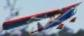

In [18]:
idx = 0
image = [Image.open(dataset['train'][idx]['image_path'])]
texts = [dataset['train'][idx]['caption'], "black helicopter", "black fighter plane", "white missile"]
print(texts)
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
model = model.to(device)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image.sigmoid() 
print(logits_per_image)
image[0]

['white, black, and grey missile', 'black helicopter', 'black fighter plane', 'white missile']
3.69270920753479
tensor([[1.0000, 0.9554, 0.8033, 0.9774]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


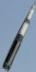

In [19]:
from time import time

start_time = time()

output_dir = 'caption_models/roberta-vit-v1-1'
vision_text_config = VisionTextDualEncoderConfig.from_pretrained(output_dir)
model = VisionTextDualEncoderModel.from_pretrained(output_dir, config=vision_text_config)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
image_processor = AutoImageProcessor.from_pretrained(output_dir)
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

idx = 1
image = [Image.open(dataset['train'][idx]['image_path'])]
texts = [dataset['train'][idx]['caption'], "black helicopter", "black fighter plane", "white missile"]
print(texts)
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to(device)
model = model.to(device)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image.sigmoid() 
print(time()-start_time)
print(logits_per_image)
image[0]